In [ ]:
!pip install torch torchvision
!pip install datasets
!pip install transformers
!pip install scikit-learn
!pip install matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from torch.optim import Adam
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import torch.nn.functional as F


In [ ]:
#Load and preprocess
ag_news = load_dataset("ag_news", split='train[:1000]')

print("Loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.eval()


def get_bert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = bert(**inputs)
    return outputs.last_hidden_state[:, 0, :]


print("Embedding articles with BERT")
texts = [x['text'] for x in ag_news]
labels = [x['label'] for x in ag_news]

embeddings = []
for i in range(0, len(texts), 32):
    batch_texts = texts[i:i + 32]
    batch_embeds = get_bert_embeddings(batch_texts)
    embeddings.append(batch_embeds)

embeddings = torch.cat(embeddings, dim=0)
print(embeddings.shape)


Loading BERT tokenizer and model...
Embedding articles with BERT
torch.Size([1000, 768])


In [ ]:
# Define Autoencoder

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

input_dim = embeddings.shape[1]

latent_dim = 64
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)

In [ ]:
# Autoencoder Train


print("Pretraining autoencoder...")

train_dataset = TensorDataset(embeddings)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

optimizer = Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

autoencoder.train()
epochs_pretrain = 10
for epoch in range(epochs_pretrain):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat, _ = autoencoder(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    print(f"Epoch {epoch+1}/{epochs_pretrain}, Reconstruction Loss: {total_loss/len(train_loader.dataset):.6f}")

Pretraining autoencoder...
Epoch 1/10, Reconstruction Loss: 0.263071
Epoch 2/10, Reconstruction Loss: 0.183562
Epoch 3/10, Reconstruction Loss: 0.151405
Epoch 4/10, Reconstruction Loss: 0.142226
Epoch 5/10, Reconstruction Loss: 0.138067
Epoch 6/10, Reconstruction Loss: 0.135245
Epoch 7/10, Reconstruction Loss: 0.132451
Epoch 8/10, Reconstruction Loss: 0.130903
Epoch 9/10, Reconstruction Loss: 0.129843
Epoch 10/10, Reconstruction Loss: 0.128757


In [ ]:
# Initializing Kmeans

autoencoder.eval()
with torch.no_grad():
    latent_embeddings = autoencoder.encoder(embeddings).numpy()

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
y_pred = kmeans.fit_predict(latent_embeddings)

cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
sil_score = silhouette_score(latent_embeddings, y_pred)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.2441966


In [ ]:
# Deep Embedded Clustering
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DEC Fine-Tuning (Modified for Higher Silhouette) ---
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def soft_assignment(z, centers):
    dist_sq = torch.sum((z.unsqueeze(1) - centers) ** 2, dim=2)
    q = 1.0 / (1.0 + dist_sq)
    q = q ** ((1 + 1) / 2)
    return (q.t() / torch.sum(q, dim=1)).t()

def target_distribution(q):
    weight = q ** 2 / torch.sum(q, dim=0)
    return (weight.t() / torch.sum(weight, dim=1)).t()

print("Starting DEC fine-tuning with silhouette tracking...")

dec_optimizer = Adam(autoencoder.parameters(), lr=5e-5)   # lower LR
autoencoder.train()

max_iter = 100
update_interval = 10
kl_weight = 0.1  # downweight KL loss to keep latent tight

for ite in range(max_iter):
    # 1) Update target distribution p every update_interval iters
    if ite % update_interval == 0:
        with torch.no_grad():
            z_all = autoencoder.encoder(embeddings.to(device))
            # Normalize z for silhouette
            z_all_np = StandardScaler().fit_transform(z_all.cpu().numpy())
            q_all = soft_assignment(z_all, cluster_centers.to(device))
            p_all = target_distribution(q_all)

        # Compute and log Silhouette on normalized latent
        cluster_labels = torch.argmax(q_all, dim=1).cpu().numpy()
        sil = silhouette_score(z_all_np, cluster_labels)
        print(f"[Iter {ite}/{max_iter}] Silhouette: {sil:.4f}")

    # 2) One epoch of DEC updates
    total_loss = 0.0
    for batch_idx, (x_batch,) in enumerate(train_loader):
        x = x_batch.to(device)
        dec_optimizer.zero_grad()
        x_hat, z_batch = autoencoder(x)

        # Soft assignments and corresponding p
        q_batch = soft_assignment(z_batch, cluster_centers.to(device))
        start = batch_idx * train_loader.batch_size
        end   = start + x.size(0)
        p_batch = p_all[start:end].to(device)

        # Compute combined loss
        recon_loss = criterion(x_hat, x)
        kl_loss    = F.kl_div(q_batch.log(), p_batch, reduction='batchmean')
        loss       = recon_loss + kl_weight * kl_loss

        loss.backward()
        dec_optimizer.step()
        total_loss += loss.item() * x.size(0)

    # Optional: log avg DEC loss
    if (ite+1) % update_interval == 0:
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[Iter {ite+1}/{max_iter}] DEC Loss: {avg_loss:.6f}")

print("DEC fine-tuning complete.")


Starting DEC fine-tuning with silhouette tracking...
[Iter 0/100] Silhouette: 0.1976
[Iter 10/100] DEC Loss: 0.195867
[Iter 10/100] Silhouette: 0.1986
[Iter 20/100] DEC Loss: 0.138007
[Iter 20/100] Silhouette: 0.1943
[Iter 30/100] DEC Loss: 0.129751
[Iter 30/100] Silhouette: 0.1966
[Iter 40/100] DEC Loss: 0.125995
[Iter 40/100] Silhouette: 0.2108
[Iter 50/100] DEC Loss: 0.123689
[Iter 50/100] Silhouette: 0.2039
[Iter 60/100] DEC Loss: 0.121802
[Iter 60/100] Silhouette: 0.1962
[Iter 70/100] DEC Loss: 0.120189
[Iter 70/100] Silhouette: 0.1894
[Iter 80/100] DEC Loss: 0.119037
[Iter 80/100] Silhouette: 0.1829
[Iter 90/100] DEC Loss: 0.118096
[Iter 90/100] Silhouette: 0.1793
[Iter 100/100] DEC Loss: 0.117210
DEC fine-tuning complete.


Silhouette Score: 0.2442
Davies-Bouldin Index: 1.2990
Calinski-Harabasz Index: 479.3102


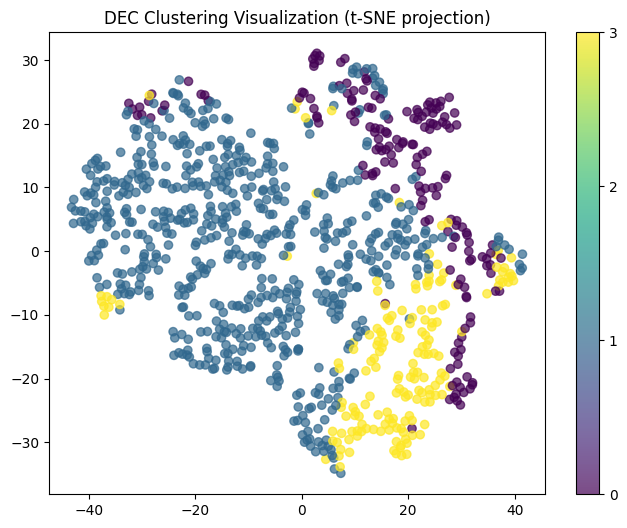

In [ ]:
# Evaluation & Visualization


autoencoder.eval()
with torch.no_grad():
    z_final = autoencoder.encoder(embeddings)
    q_final = soft_assignment(z_final, cluster_centers)
    y_dec = torch.argmax(q_final, dim=1).numpy()

sil_score = silhouette_score(latent_embeddings, y_pred)
db_score = davies_bouldin_score(latent_embeddings, y_dec)
ch_score = calinski_harabasz_score(latent_embeddings, y_dec)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")


tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_final.numpy())

plt.figure(figsize=(8,6))
scatter = plt.scatter(z_2d[:,0], z_2d[:,1], c=y_dec, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(n_clusters))
plt.title("DEC Clustering Visualization (t-SNE projection)")
plt.show()